In [6]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import anndata as ad
from muon import prot as pt
import squidpy as sq
import scanpy as sc
import plotnine as p9

In [7]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData
li.__version__

'1.0.0a0'

In [8]:
# from https://www.hcdm.org/index.php/molecule-information
cd_to_ncbi = pd.read_csv("CD_to_ncbi.txt", sep="\t", header=None, names=["CD_NAME", "NCBI_NAME", "GENE_NAME", "NCBI_OTHER_NAME"])
cd_to_ncbi.NCBI_OTHER_NAME = [str(s).split(";") for s in cd_to_ncbi.NCBI_OTHER_NAME]
cd_to_ncbi

,CD_NAME,NCBI_NAME,GENE_NAME,NCBI_OTHER_NAME
0,CD1a,CD1A,CD1A,[CD1]
1,CD1b,CD1B,CD1B,[CD1]
2,CD1c,CD1C,CD1C,[CD1]
3,CD1d,CD1D,CD1D,[none]
4,CD1e,CD1E,CD1E,[HSCDIEL]
...,...,...,...,...
412,CD367,CLEC4A,CD367,"[DCIR, DDB27, CLECSF6]"
413,CD368,CLEC4D,CD368,"[MCL, CLECSF8, CLEC-6, MPCL]"
414,CD369,CLEC7A,CD369,"[DECTIN-1, CLECSF12,]"
415,CD370,CLEC9A,CD370,"[HEEE9341, UNQ9341, DNGR1]"


In [6]:
#from pybiomart import Dataset
#dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
##with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
##    display(dataset.list_attributes())
## or check attributes here: https://www.ensembl.org/biomart/martview
#
#gene_annot = dataset.query(attributes=["ensembl_gene_id", "external_gene_name", "hgnc_symbol", "uniprot_gn_symbol", "wikigene_name"])
#gene_annot
#
#gene_annot_2 = dataset.query(attributes=["ensembl_gene_id", "external_gene_name", "hgnc_id"])
#hgnc = pd.read_csv("group-471.csv", skiprows=1).rename(columns={'HGNC ID (gene)':'HGNC ID'})
#gene_annot_2 = gene_annot_2.set_index("HGNC ID").join(hgnc, how="left")
#gene_annot_2

# bar foo
#print(np.array([s in gene_annot["Gene name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot["HGNC symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot["UniProtKB Gene Name symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot["WikiGene name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#
#print(np.array([s in gene_annot_2["Approved symbol"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot_2["Approved name"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot_2["Previous symbols"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())
#print(np.array([s in gene_annot_2["Aliases"].to_numpy() for s in barcodes.loc[~barcodes.matched, :].Primary.to_numpy()]).sum())

In [9]:
rna_path = "/Users/pschafer/Liana_Vignette/data/GSE213264/GSM6578062_humantonsil_RNA.tsv.gz"
prot_path = "/Users/pschafer/Liana_Vignette/data/GSE213264/GSM6578071_humantonsil_protein.tsv.gz"
ab_path = "/Users/pschafer/Liana_Vignette/data/41587_2023_1676_MOESM3_ESM.xlsx"

In [10]:
# sheets: HUMAN_273, MOUSE_189
ab_df = pd.read_excel(ab_path, sheet_name="HUMAN_273")

In [11]:
rna = pd.read_csv(rna_path, sep="\t")
prot = pd.read_csv(prot_path, sep="\t")
assert set(rna.X) == set(prot.X)

rna = rna.set_index("X")
prot = prot.set_index("X")
prot = prot.loc[rna.index]
assert np.all(rna.index == prot.index)

In [12]:
# get coordinates
def get_coord(col):
    x_coord = [s.split("x")[0] for s in col]
    y_coord = [s.split("x")[1] for s in col]
    df_coord = pd.DataFrame({"x": x_coord, "y": y_coord})
    df_coord = df_coord.apply(pd.to_numeric)
    return df_coord
coord = get_coord(rna.index)

In [13]:
# remove spike ins from rna
print(rna.shape)
spike_bool = np.array(["ERCC" in c for c in rna.columns])
print(spike_bool.sum())
rna = rna.loc[:,~spike_bool]
print(rna.shape)

(2492, 28417)
29
(2492, 28388)


In [14]:
# TODO: remove unmapped from protein?
print(prot.shape)
unmapped_bool = np.array(["unmapped" in c for c in prot.columns])
print(unmapped_bool.sum())
prot = prot.loc[:,~unmapped_bool]
print(prot.shape)

(2492, 283)
1
(2492, 282)


In [15]:
# clean protein names
clean_names = prot.columns
clean_names = [re.sub("\\.[AGCT]{15}", "", s) for s in prot.columns]
clean_names = [re.sub("anti\\.mouse\\.human", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.human\\.mouse", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.mouse\\.rat\\.human", "", s) for s in clean_names]
clean_names = [re.sub("anti\\.mouse\\.rat", "", s) for s in clean_names]
clean_names = [re.sub("Mouse", "", s) for s in clean_names]
clean_names = [re.sub("Rat", "", s) for s in clean_names]
clean_names = [re.sub("Human", "", s) for s in clean_names]
clean_names = [re.sub("isotype\\.Ctrl", "", s) for s in clean_names]
clean_names = [re.sub("Isotype\\.Ctrl", "", s) for s in clean_names]
clean_names = [re.sub("\\.\\.k", "", s) for s in clean_names]
clean_names = [re.sub("\\.+$", "", s) for s in clean_names]
clean_names = [re.sub("^\\.+", "", s) for s in clean_names]

In [16]:
# merge from barcode excel sheet and clean names gain
barcodes = np.array([re.search("[AGCT]{15}|unmapped", s).group() for s in prot.columns])
barcodes = pd.DataFrame({"barcode": barcodes}).join(ab_df.set_index("Barcode"), on="barcode")
barcodes["Clean"] = clean_names
barcodes["Target"] = [re.sub("anti-human ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-human/mouse ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-mouse/human ", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("Recombinant", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-Human", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [re.sub("anti-", "", s) for s in barcodes["Target"].to_numpy()]
barcodes["Target"] = [s.strip() for s in barcodes["Target"].to_numpy()]

In [17]:
# extract all names in the bracket in s and put into a list
def extract_names(s):
    pattern = re.compile(r'\((.*?)\)')
    return pattern.findall(s)

# remove the bracket in s and put into a list
def remove_bracket(s):
    pattern = re.compile(r' \((.*?)\)')
    return pattern.sub('', s)

primary_names = []
alternative_names = []
for bc, target in zip(barcodes.barcode, barcodes.Target):
    primary_names.append(remove_bracket(target))
    alternative_names.append(extract_names(target))

barcodes["Primary"] = [s.strip() for s in primary_names]
barcodes["Alternative"] = alternative_names
barcodes = barcodes.set_index("Primary").join(cd_to_ncbi.set_index("CD_NAME"), how="left")
barcodes = barcodes.reset_index().rename(columns={"index": "Primary"})
barcodes = barcodes.fillna("none")
barcodes

,Primary,barcode,DNA_ID,Target,Clean,Alternative,NCBI_NAME,GENE_NAME,NCBI_OTHER_NAME
0,CD64,AAGTATGCCCTACGA,A0162,CD64,CD64,[],none,none,none
1,CD1d,TCGAGTCGCTTATCA,A0164,CD1d,CD1d,[],CD1D,CD1D,[none]
2,CD270,TGATAGAAACAGACC,A0020,"CD270 (HVEM, TR2)",CD270..HVEM_.TR2,"[HVEM, TR2]",TNFRSF14,CD270,"[ATAR, CD270, ""herpesvirus entry mediator"", ..."
3,CD319,AGTATGCCATGTCTT,A0830,CD319 (CRACC),CD319..CRACC,[CRACC],SLAMF7,CD319,"[19A, CRACC, CS1]"
4,CD34,GCAGAAATCTCCCTT,A0054,CD34,CD34,[],CD34,CD34,[none]
...,...,...,...,...,...,...,...,...,...
277,CD37,ACAGTCACTGGGCAA,A0941,CD37,CD37,[],CD37,CD37,[GP52-40]
278,TNF-α,CCTATGAACGTAACG,A0945,TNF-α,TNF.a,[],none,none,none
279,CD215,CATATTCCGCCGTAA,A0947,CD215 (IL-15Rα),CD215..IL.15Ra,[IL-15Rα],IL15RA,CD215,"[CD215, IL-15RA]"
280,CD321,GACAGTACCGACACT,A0948,CD321,CD321,[],F11R,CD321,"[JAM, KAT, JAM1, JCAM, JAM-1, PAM-1]"


In [18]:
#li.rs.show_resources()
db = li.rs.select_resource("consensus")
ligands_orig = np.unique(db.ligand.to_numpy())
receptors_orig = np.unique(db.receptor.to_numpy())
print(ligands_orig.shape)
print(receptors_orig.shape)

(1036,)
(1059,)


In [19]:
# any overlap between ligands and receptors?
print(len(set(ligands_orig) & set(receptors_orig)))
np.array(list(set(ligands_orig) & set(receptors_orig)))

62


array(['ACTR2', 'TNFSF8', 'CNTN1', 'NECTIN4', 'NECTIN1', 'HLA-DPB1',
       'FGFR3', 'NECTIN2', 'DSCAM', 'NRXN3', 'ADAM23', 'CD86', 'ITGAV',
       'SELL', 'CFC1', 'HAVCR1', 'NLGN1', 'HLA-DPA1', 'SPN', 'GP1BA',
       'NLGN2', 'CRTAM', 'APP', 'SCUBE2', 'CLEC1B', 'MUC1', 'CSPG4',
       'CEACAM5', 'IL1RAPL1', 'CLEC2D', 'DSC3', 'CD200', 'CD200R1',
       'MADCAM1', 'SIRPA', 'SIRPG', 'SEMA4C', 'CD96', 'CD72', 'PDPN',
       'PODXL', 'CEACAM1', 'TIGIT', 'NLGN3', 'FGFR4', 'NRXN1', 'DSC1',
       'C1QB', 'NTRK3', 'NRXN2', 'CD47', 'THY1', 'CD80', 'RGMB', 'CXADR',
       'ITGB2', 'CD22', 'CD70', 'SDC2', 'JAML', 'CADM1', 'CD28'],
      dtype='<U8')

In [20]:
# for now we remove entries that are annotated as both receptors and ligands
# TODO: Change in future
ligands = np.array(list(set(ligands_orig) - (set(ligands_orig) & set(receptors_orig))))
receptors = np.array(list(set(receptors_orig) - (set(ligands_orig) & set(receptors_orig))))
print(ligands.shape)
print(receptors.shape)

(974,)
(997,)


In [21]:
# custom list to translate names
translate_names = {
    "CD270": "TNFRSF14",
    "CD335": "NCR1",
    "CD117": "KIT",
    "CD357": "TNFRSF18",
    "CD268": "TNFRSF13C",
    "CD252": "TNFSF4",
    "CD137L": "TNFSF9", # ligand for CD137: TNFRSF9
    "TNF-α" : "TNF",
    "LOX-1": "OLR1",
    "TSLPR": "CRLF2",
    "CD273": "PDCD1LG2",
    "CD169": "SIGLEC1",
    "β2-microglobulin": "B2M",
    "FcεRIα": "FCER2",
    "CD294": "PTGDR2",
    "integrin β7": "ITGB7",
    "CD32": "FCGR2A",
    "CD85j": "LILRB1",
    "CD158": "CD40LG",
    "Mac-2": "LGALS3",
    "Podoplanin": "PDPN",
    "CD8": "CD8A",
    "CD122": "IL2RB",
    "Galectin-9": "LGALS9",
    "Cadherin 11": "CDH11",
    "Notch 1": "NOTCH1",
    "CD119": "IFNGR1",
    "Notch 3": "NOTCH3",
    "CD85g": "LILRA4",
    "TIM-4": "TIMD4",
    "C5L2": "C5AR2",
    "mast cell tryptase": "TPSAB1",
    "GP130": "IL6ST",
    "CD218a": "IL18R1",
    "VEGFR-3": "FLT4",
    "GPR56": "ADGRG1",
    "MICA/MICB": "MICA",
    "NKp80": "KLRF1",
    "CD131": "CSF2RB",
    "Lymphotoxin β Receptor": "LTBR",
    "Annexin A1": "ANXA1",
}
barcodes["MANUAL"] = [translate_names.get(s, "none") for s in barcodes.Primary]

In [22]:
match_bool_receptors = np.zeros(len(barcodes), dtype=bool)
matched_receptors = []

for i, row_dict in enumerate(barcodes.to_dict(orient="records")):
    
    if row_dict["Primary"] in receptors:
        matched_receptors.append(row_dict["Primary"])
        match_bool_receptors[i] = True
        continue

    if row_dict["NCBI_NAME"] in receptors:
        matched_receptors.append(row_dict["NCBI_NAME"])
        match_bool_receptors[i] = True
        continue

    if row_dict["MANUAL"] in receptors:
        matched_receptors.append(row_dict["MANUAL"])
        match_bool_receptors[i] = True
        continue

    tmp_flag = False
    for entry in row_dict["NCBI_OTHER_NAME"]:
        if entry.strip() in receptors:
            matched_receptors.append(entry.strip() )
            match_bool_receptors[i] = True
            tmp_flag = True
            break
    if tmp_flag:
        continue

    tmp_flag = False
    for entry in row_dict["Alternative"]:
        if entry.strip() in receptors:
            matched_receptors.append(entry.strip() )
            match_bool_receptors[i] = True
            tmp_flag = True
            break
    if tmp_flag:
        continue

    matched_receptors.append("none")

barcodes["matched_receptor_bool"] = match_bool_receptors
match_bool_receptors.sum()

133

In [23]:
match_bool_ligands = np.zeros(len(barcodes), dtype=bool)
matched_ligands = []

for i, row_dict in enumerate(barcodes.to_dict(orient="records")):
    
    if row_dict["Primary"] in ligands:
        matched_ligands.append(row_dict["Primary"])
        match_bool_ligands[i] = True
        continue

    if row_dict["NCBI_NAME"] in ligands:
        matched_ligands.append(row_dict["NCBI_NAME"])
        match_bool_ligands[i] = True
        continue

    if row_dict["MANUAL"] in ligands:
        matched_ligands.append(row_dict["MANUAL"])
        match_bool_ligands[i] = True
        continue

    tmp_flag = False
    for entry in row_dict["NCBI_OTHER_NAME"]:
        if entry.strip() in ligands:
            matched_ligands.append(entry.strip() )
            match_bool_ligands[i] = True
            tmp_flag = True
            break
    if tmp_flag:
        continue

    tmp_flag = False
    for entry in row_dict["Alternative"]:
        if entry.strip() in ligands:
            matched_ligands.append(entry.strip() )
            match_bool_ligands[i] = True
            tmp_flag = True
            break
    if tmp_flag:
        continue

    matched_ligands.append("none")

barcodes["matched_ligand_bool"] = match_bool_ligands
match_bool_ligands.sum()

52

In [26]:
barcodes["matched"] = np.logical_or(barcodes["matched_receptor_bool"], barcodes["matched_ligand_bool"])

barcodes["matched_receptor"] = matched_receptors
barcodes["matched_ligand"] = matched_ligands

matched_receptors = np.array(matched_receptors)[[s != "none" for s in matched_receptors]]
matched_ligands = np.array(matched_ligands)[[s != "none" for s in matched_ligands]]

assert set(list(matched_receptors)) & set(list(matched_ligands)) == set()

In [27]:
barcodes.loc[barcodes.matched]

,Primary,barcode,DNA_ID,Target,Clean,Alternative,NCBI_NAME,GENE_NAME,NCBI_OTHER_NAME,MANUAL,matched_receptor_bool,matched_ligand_bool,matched,matched_receptor,matched_ligand
1,CD1d,TCGAGTCGCTTATCA,A0164,CD1d,CD1d,[],CD1D,CD1D,[none],none,False,True,True,none,CD1D
2,CD270,TGATAGAAACAGACC,A0020,"CD270 (HVEM, TR2)",CD270..HVEM_.TR2,"[HVEM, TR2]",TNFRSF14,CD270,"[ATAR, CD270, ""herpesvirus entry mediator"", ...",TNFRSF14,True,False,True,TNFRSF14,none
4,CD34,GCAGAAATCTCCCTT,A0054,CD34,CD34,[],CD34,CD34,[none],none,False,True,True,none,CD34
5,CD335,ACAATTTGAACAGCG,A0101,CD335 (NKp46),CD335..NKp46,[NKp46],NCR1,CD335,"[LY94, NK-p46, NKP46]",NCR1,True,False,True,NCR1,none
6,CD193,ACCAATCCTTTCGTC,A0397,CD193 (CCR3),CD193..CCR3,[CCR3],CCR3,CD193,"[CC-CKR-3, CKR3, CMKBR3]",none,True,False,True,CCR3,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,CD317,AAGAGCCGTTGTGAA,A0936,"CD317 (BST2, Tetherin)",CD317..BST2_.Tetherin,"[BST2, Tetherin]",BST2,CD317,[none],none,False,True,True,none,BST2
276,CD116,ATGGACAGTTCGTGT,A0940,CD116,CD116,[],CSF2RA,CD116,"[CD116, CDw116, CSF2R, CSF2RAX, CSF2RAY, ...",none,True,False,True,CSF2RA,none
278,TNF-α,CCTATGAACGTAACG,A0945,TNF-α,TNF.a,[],none,none,none,TNF,False,True,True,none,TNF
279,CD215,CATATTCCGCCGTAA,A0947,CD215 (IL-15Rα),CD215..IL.15Ra,[IL-15Rα],IL15RA,CD215,"[CD215, IL-15RA]",none,False,True,True,none,IL15RA


In [28]:
# almost all of the matched ligands and receptors are in the rna data (only 6 are missing)
print(set(list(matched_ligands) + list(matched_receptors)) - set(rna.columns.to_list()))

matched_ligands = np.array([l for l in matched_ligands if l in rna.columns.to_list()])
matched_receptors = np.array([l for l in matched_receptors if l in rna.columns.to_list()])

assert set(list(matched_ligands) + list(matched_receptors)) - set(rna.columns.to_list()) == set()

{'ADGRG1', 'MPL', 'CD177', 'PECAM1', 'CD24', 'HLA-E'}


In [26]:
# code to to match antibody names to ligands or receptors
#g = "CD21"
#print(receptors[np.array([g in l for l in receptors])])
#print(ligands[np.array([g in l for l in ligands])])

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    display(barcodes.loc[~barcodes.matched, :].loc[:, ["Primary"]])

In [29]:
db_subset = db.loc[np.logical_or(np.array([s in np.unique(matched_receptors) for s in db.receptor.to_numpy()]),
                                 np.array([s in np.unique(matched_ligands) for s in db.ligand.to_numpy()]))]
db_subset

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47
...,...,...
4684,NRG3,EGFR
4685,CSF1,CSF2RA
4686,CSF3,CSF2RA
4688,MAML2,NOTCH3


In [30]:
print(db.shape)

# subset for matched ligand and receptors
db_subset = db.loc[np.logical_or(np.array([s in np.unique(matched_receptors) for s in db.receptor.to_numpy()]),
                                 np.array([s in np.unique(matched_ligands) for s in db.ligand.to_numpy()]))]
print(db_subset.shape)

# subset for genes that are in our RNA dataset
all_genes = np.unique(db_subset.ligand.to_list() + db_subset.receptor.to_list())
all_genes_in_rna = all_genes[[s in rna.columns for s in all_genes]]

db_subset = db_subset.loc[np.logical_and(np.array([s in all_genes_in_rna for s in db_subset.receptor.to_numpy()]),
                                         np.array([s in all_genes_in_rna for s in db_subset.ligand.to_numpy()]))]
print(db_subset.shape)

(4701, 2)
(958, 2)
(819, 2)


In [31]:
print(all_genes.shape)
print(all_genes_in_rna.shape)

(701,)
(618,)


In [32]:
misty_predictors = np.union1d(np.unique(matched_receptors), np.unique(matched_ligands))
misty_predictors = np.array([s for s in misty_predictors if s in list(set(db_subset.ligand.to_list() + db_subset.receptor.to_list()))])
print(misty_predictors.shape)

misty_targets = np.array(list(set(list(set(db_subset.ligand.to_list() + db_subset.receptor.to_list()))) - set(list(misty_predictors))))
print(misty_targets.shape)

# check that misty targets (genes with ADT) and misty predictors have no overlap
assert set(list(misty_predictors)) & set(list(misty_targets)) == set()
assert len(set(db_subset.ligand.to_list() + db_subset.receptor.to_list())) == len(set(misty_predictors) | set(misty_targets))

(166,)
(444,)


In [33]:
barcode_to_match = {}
for row_dict in barcodes.to_dict(orient="records"):
    if row_dict["matched_receptor_bool"]:
        if row_dict["matched_receptor"] in rna.columns:
            barcode_to_match[row_dict["barcode"]] = row_dict["matched_receptor"]
    elif row_dict["matched_ligand_bool"]:
        if row_dict["matched_ligand"] in rna.columns:
            barcode_to_match[row_dict["barcode"]] = row_dict["matched_ligand"]
len(barcode_to_match)

178

In [36]:
prot.columns = barcodes["barcode"]
prot_predictor = prot.loc[:, list(barcode_to_match.keys())]
prot_predictor.columns = [barcode_to_match[s] for s in prot_predictor.columns]

rna_predictor = rna.loc[:, prot_predictor.columns]
rna_target = rna.loc[:, misty_targets]

In [36]:
#markers = ["CD19", "CD21", "CD23"]
#fig, axs = plt.subplots(1, len(markers), figsize=(15, 5))
#for i, marker in enumerate(markers):
#    plot_df = coord.copy()
#    plot_df["marker"] = prot[marker].to_numpy()
#    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[i], s=20)
#    axs[i].axis('equal')
#    axs[i].invert_yaxis()
#    axs[i].set_title(marker)
#plt.show()
#
#markers = ["IgM", "IgG.Fc", "IgD"]
#fig, axs = plt.subplots(1, len(markers), figsize=(15, 5))
#for i, marker in enumerate(markers):
#    plot_df = coord.copy()
#    plot_df["marker"] = prot[marker].to_numpy()
#    sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[i], s=20)
#    axs[i].axis('equal')
#    axs[i].invert_yaxis()
#    axs[i].set_title(marker)
#plt.show()

In [37]:
obs_df = rna.index.to_frame(name="name")
obs_df["x"] = coord["x"].to_numpy()
obs_df["y"] = coord["y"].to_numpy()

spatial = obs_df.copy().loc[:, ["x", "y"]]
spatial

,x,y
X,,
29x42,29,42
44x36,44,36
34x6,34,6
42x19,42,19
41x6,41,6
...,...,...
2x26,2,26
30x26,30,26
23x48,23,48


In [38]:
rna_target_ad = ad.AnnData(X=rna_target.to_numpy(), var=rna_target.columns.to_frame(name="mRNA"), obs=rna_target.index.to_frame(name="id"), obsm={"spatial": spatial})
rna_predictor_ad = ad.AnnData(X=rna_predictor.to_numpy(), var=rna_predictor.columns.to_frame(name="mRNA"), obs=rna_predictor.index.to_frame(name="id"), obsm={"spatial": spatial})
prot_predictor_ad = ad.AnnData(X=prot_predictor.to_numpy(), var=prot_predictor.columns.to_frame(name="protein"), obs=prot_predictor.index.to_frame(name="id"), obsm={"spatial": spatial})

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [39]:
print(rna_target_ad)
print(rna_predictor_ad)
print(prot_predictor_ad)

AnnData object with n_obs × n_vars = 2492 × 444
    obs: 'id'
    var: 'mRNA'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2492 × 178
    obs: 'id'
    var: 'mRNA'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2492 × 178
    obs: 'id'
    var: 'protein'
    obsm: 'spatial'


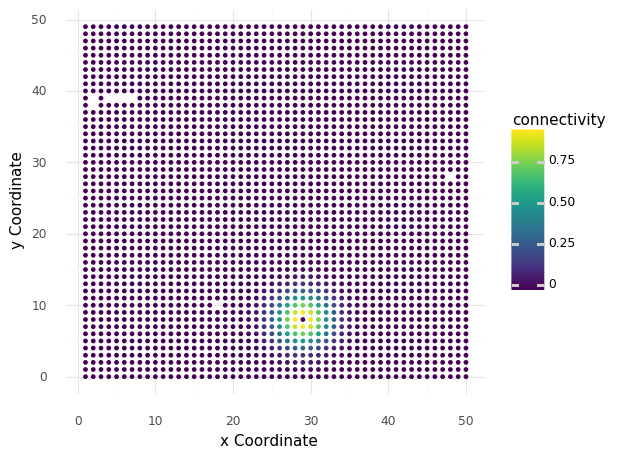

<ggplot: (274907197)>

In [40]:
li.ut.spatial_neighbors(rna_predictor_ad, cutoff=0, bandwidth=2.5, set_diag=False)
li.ut.spatial_neighbors(prot_predictor_ad, cutoff=0, bandwidth=2.5, set_diag=False)
li.pl.connectivity(rna_predictor_ad, idx=0)

In [43]:
misty = MistyData(data={"intra": rna_target_ad, "para_rna": rna_predictor_ad, "para_adt": prot_predictor_ad})
misty.var_names_make_unique() # otherwise we cannot index
misty

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:288: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:288: UserWarning: Duplicated var_names should not be present in different modalities due to the ambiguity that leads to.
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:445: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:457: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/mudata/_core/mudata.py:1019: UserWarning: Modality names will be prepended to var_names since there are identical var

MuData object with n_obs × n_vars = 2492 × 800
  obs:	'id'
  3 modalities
    intra:	2492 x 444
      obs:	'id'
      var:	'mRNA'
      obsm:	'spatial'
    para_rna:	2492 x 178
      obs:	'id'
      var:	'mRNA'
      obsm:	'spatial'
      obsp:	'spatial_connectivities'
    para_adt:	2492 x 178
      obs:	'id'
      var:	'protein'
      obsm:	'spatial'
      obsp:	'spatial_connectivities'

In [56]:
# QC remove all features with very few counts (below 10)
print((np.asarray(misty.mod["intra"].X.sum(axis=0)).squeeze() < 10).sum())
print((np.asarray(misty.mod["para_rna"].X.sum(axis=0)).squeeze() < 10).sum())
print((np.asarray(misty.mod["para_adt"].X.sum(axis=0)).squeeze() < 10).sum())

94
12
0


In [43]:
#misty(model='linear', verbose=True, bypass_intra=True)
misty(model="rf", verbose=True, bypass_intra=True)

Now learning: intra:TNC: 100%|██████████| 444/444 [1:02:42<00:00,  8.48s/it]     


In [44]:
target_subset = misty.uns['target_metrics'].target[misty.uns['target_metrics'].gain_R2 > 0]

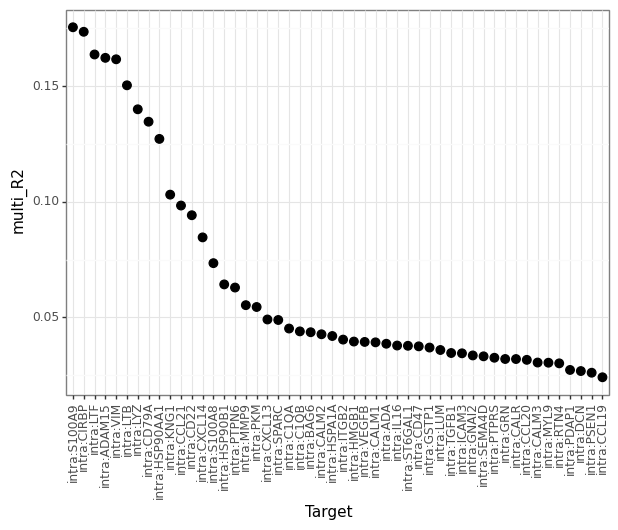

<ggplot: (707300012)>

In [45]:
stat = "multi_R2"
target_metrics = misty.uns['target_metrics'].copy()

target_metrics = target_metrics.sort_values(stat, ascending=False).head(50)

# get order of target by decreasing intra.R2
targets = target_metrics.sort_values(by=stat, ascending=False)['target'].values
# targets as categorical variable
target_metrics['target'] = pd.Categorical(target_metrics['target'],
                                            categories=targets, 
                                            ordered=True)

p = (p9.ggplot(target_metrics, p9.aes(x='target', y=stat)) +
        p9.geom_point(size=3) + 
        p9.theme_bw() +
        p9.theme(axis_text_x=p9.element_text(rotation=90),
                figure_size=(7,5)) +
    p9.labs(x='Target')
    )
p

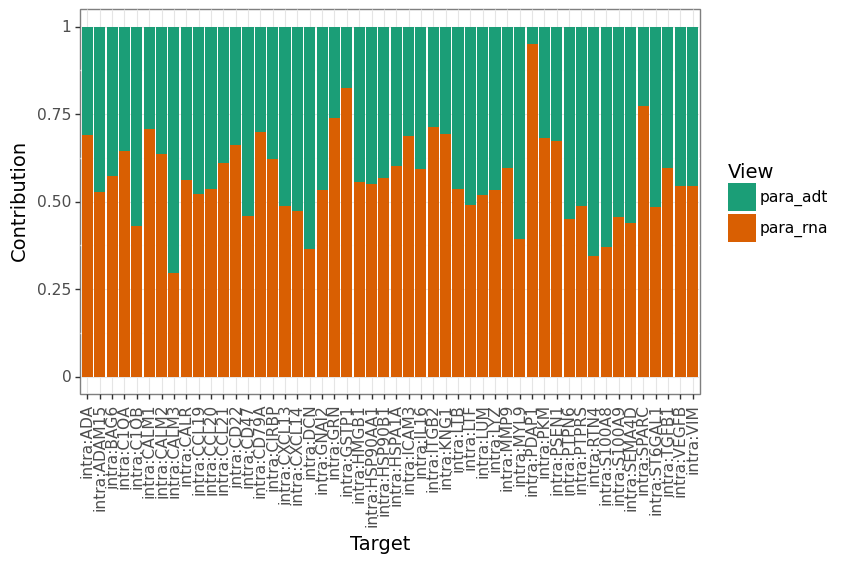

<ggplot: (707322929)>

In [46]:
target_metrics = misty.uns['target_metrics'].copy()

target_metrics = target_metrics.sort_values(stat, ascending=False).head(50)

view_names = misty.view_names.copy()
if 'intra' not in target_metrics.columns:
    view_names.remove('intra')

target_metrics = target_metrics[['target', *view_names]]
target_metrics = target_metrics.melt(id_vars='target', var_name='view', value_name='contribution')

p = (p9.ggplot(target_metrics, p9.aes(x='target', y='contribution', fill='view')) +
        p9.geom_bar(stat='identity') +
        p9.theme_bw(base_size=14) +
        p9.theme(axis_text_x=p9.element_text(rotation=90),
                    figure_size=(8,5)) +
        p9.scale_fill_brewer(palette=2, type='qual') +
        p9.labs(x='Target', y='Contribution', fill='View')
)
p

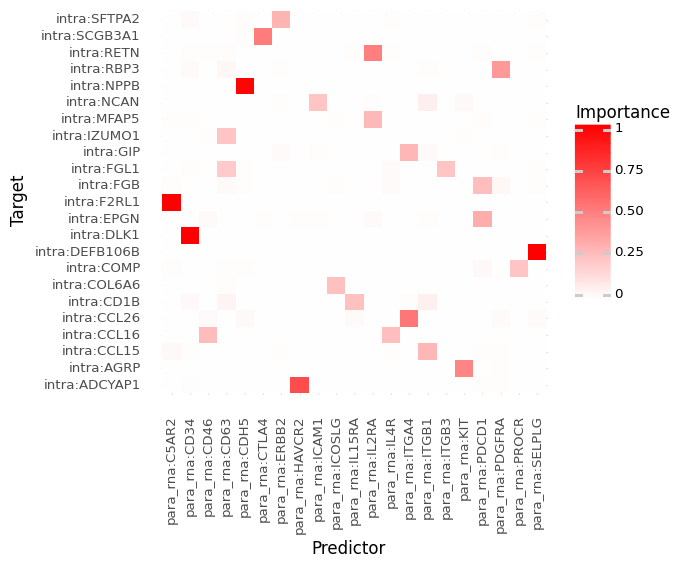

<ggplot: (671151120)>

In [47]:
(
    li.pl.interactions(misty, 'para_rna', return_fig=True, figure_size=(5, 5), top_n=25, key=abs) +
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    p9.labs(y='Target', x='Predictor')
)

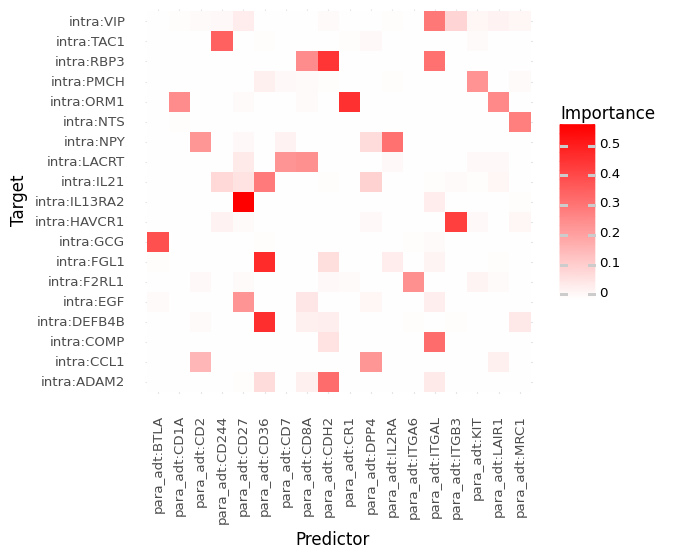

<ggplot: (714460305)>

In [48]:
(
    li.pl.interactions(misty, 'para_adt', return_fig=True, figure_size=(5, 5), top_n=25, key=abs) +
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    p9.labs(y='Target', x='Predictor')
)